
Text-guided Image Colorization (UNet + FiLM conditioning on CLIP text embeddings)
Dataset: efekankavalci/flowers102-captions (HuggingFace)

Prerequisites:
- Python 3.8+
- PyTorch
- torchvision
- transformers
- datasets
- Pillow
- scikit-learn (for potential color mapping)

This script/notebook contains:
1) dataset loading + filtering by presence of color words in captions
2) train/test split and PyTorch Dataset + DataLoader
3) UNet-like autoencoder that receives grayscale image + text embedding and outputs color RGB image
   - Conditioning via FiLM (generate gamma/beta from text embedding)
4) Training loop with MSE loss and Adam optimizer
5) Test cell that plots: input grayscale, reconstructed color, and ground-truth color image along with used prompt



In [3]:
! pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvi

In [4]:
import os
import re
import math
from typing import List
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Hugging Face
from datasets import load_dataset
from transformers import CLIPTokenizer, CLIPTextModel

from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import lpips 

# -----------------------------
# Config
# -----------------------------
DATASET_ID = "efekankavalci/flowers102-captions"
IMAGE_SIZE = 128
BATCH_SIZE = 16
NUM_WORKERS = 4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "models_v2"
os.makedirs(SAVE_DIR, exist_ok=True)
print("go on ")

2025-12-14 15:57:02.203806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765727822.371554      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765727822.417545      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

go on 


### filtrado de colores

In [12]:
# -----------------------------
# Color word filter (English)
# -----------------------------
# A conservative list of common color words/phrases.
COLOR_WORDS = [
    "white","black","red","green","blue","yellow","purple","pink","orange","brown",
    "gray","grey","magenta","maroon","violet","indigo","azure","teal","cyan","beige",
    "gold","silver","bronze","peach","lavender","cream","olive","lime","salmon","coral",
    "turquoise","amber","plum","cherry","emerald","ivory","charcoal","scarlet","navy"
]

# create regex to match color words and simple modifiers like "light", "dark"
COLOR_RE = re.compile(r"\b(?:light|dark|pale|deep|bright|dull)?\s*(?:" + r"|".join(re.escape(c) for c in COLOR_WORDS) + r")s?\b",
                      flags=re.IGNORECASE)

def has_color_word(text: str) -> bool:
    if text is None:
        return False
    return bool(COLOR_RE.search(text))

# -----------------------------
# Dataset + Filtering
# -----------------------------
class FlowersColorDataset(Dataset):
    def __init__(self, hf_split, tokenizer, max_length=32, image_size=IMAGE_SIZE, mode='train'):
        self.dataset = hf_split
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.image_size = image_size

        self.transform_input = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.Grayscale(num_output_channels=1),  # input is grayscale
            transforms.ToTensor(),                        # -> [0,1]
        ])
        self.transform_target = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),                        # RGB target [0,1]
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # 'image' is a PIL image
        img = item['image']
        text = item['text']

        # prepare inputs
        inp = self.transform_input(img)  # 1 x H x W
        target = self.transform_target(img)  # 3 x H x W

        # tokenization
        tokens = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        # return tensors
        sample = {
            'gray': inp,
            'rgb': target,
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'text': text
        }
        return sample
print("defined")

defined


### Crear modelos

In [13]:
# -----------------------------
# Utilities: text embedding wrapper
# -----------------------------
class TextEncoder:
    def __init__(self, model_name="openai/clip-vit-base-patch32", device=DEVICE):
        self.device = device
        self.tokenizer = CLIPTokenizer.from_pretrained(model_name)
        self.model = CLIPTextModel.from_pretrained(model_name).to(device)
        self.model.eval()

    def encode(self, input_ids, attention_mask):
        # input_ids: (B, L)
        with torch.no_grad():
            input_ids = input_ids.to(self.device)
            attention_mask = attention_mask.to(self.device)
            out = self.model(input_ids=input_ids, attention_mask=attention_mask)
            # use pooled or mean of last_hidden_state
            # CLIPTextModel returns last_hidden_state: (B, L, D)
            last = out.last_hidden_state
            # mean pooling with mask
            mask = attention_mask.unsqueeze(-1)
            masked = last * mask
            summed = masked.sum(1)
            denom = mask.sum(1).clamp(min=1e-9)
            emb = summed / denom
            return emb  # (B, D)

# -----------------------------
# Training loop
# -----------------------------

def collate_fn(batch):
    # stack tensors and keep text tensors
    gray = torch.stack([b['gray'] for b in batch])
    rgb = torch.stack([b['rgb'] for b in batch])
    input_ids = torch.stack([b['input_ids'] for b in batch])
    attention_mask = torch.stack([b['attention_mask'] for b in batch])
    texts = [b['text'] for b in batch]
    return {'gray': gray, 'rgb': rgb, 'input_ids': input_ids, 'attention_mask': attention_mask, 'text': texts}
print("defined")

defined


In [14]:
# -----------------------------
# Model: UNet-like autoencoder + FiLM-conditioning
# -----------------------------

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, down=True):
        super().__init__()
        if down:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )
    def forward(self, x):
        return self.conv(x)


class FiLM(nn.Module):
    """Genera gamma/beta para 'channels' canales a partir del embedding de texto."""
    def __init__(self, text_dim, channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(text_dim, max(text_dim // 2, 32)),
            nn.ReLU(inplace=True),
            nn.Linear(max(text_dim // 2, 32), channels * 2)
        )
    def forward(self, text_emb):
        # text_emb: (B, text_dim)
        out = self.net(text_emb)           # (B, channels*2)
        gamma, beta = out.chunk(2, dim=-1) # each (B, channels)
        gamma = gamma.unsqueeze(-1).unsqueeze(-1)  # (B, channels, 1, 1)
        beta  = beta.unsqueeze(-1).unsqueeze(-1)
        return gamma, beta


class TextCondUNet(nn.Module):
    def __init__(self, text_dim=512, base_ch=64):
        super().__init__()
        self.text_dim = text_dim
        # encoder
        self.enc1 = ConvBlock(1, base_ch, down=True)            # -> 64
        self.enc2 = ConvBlock(base_ch, base_ch*2, down=True)    # -> 128
        self.enc3 = ConvBlock(base_ch*2, base_ch*4, down=True)  # -> 256
        self.enc4 = ConvBlock(base_ch*4, base_ch*8, down=True)  # -> 512

        # bottleneck (keeps 512 channels)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_ch*8, base_ch*8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # FiLMs
        self.film_bottleneck = FiLM(text_dim, base_ch*8)  # para 'b' (512)
        self.film_d4 = FiLM(text_dim, base_ch*8)         # para d4 after concat (512)
        self.film_d3 = FiLM(text_dim, base_ch*4)         # para d3 after concat (256)
        self.film_d2 = FiLM(text_dim, base_ch*2)         # para d2 after concat (128)

        # decoder (transpose convs)
        self.dec4 = ConvBlock(base_ch*8, base_ch*4, down=False)  # in 512 -> out 256
        self.dec3 = ConvBlock(base_ch*8, base_ch*2, down=False)  # in 512 -> out 128
        self.dec2 = ConvBlock(base_ch*4, base_ch, down=False)    # in 256 -> out 64
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def apply_film(self, feat, gamma, beta):
        # feat: (B,C,H,W), gamma/beta: (B,C,1,1)
        # broadcasting hará que se apliquen por canal
        return feat * (1 + gamma) + beta

    def forward(self, gray, text_emb):
        # Encoder
        e1 = self.enc1(gray)   # (B, 64, H/2, W/2)
        e2 = self.enc2(e1)     # (B, 128, H/4, W/4)
        e3 = self.enc3(e2)     # (B, 256, H/8, W/8)
        e4 = self.enc4(e3)     # (B, 512, H/16, W/16)

        # Bottleneck + FiLM (512)
        b = self.bottleneck(e4)                      # (B, 512, H/16, W/16)
        gb, bb = self.film_bottleneck(text_emb)      # (B,512,1,1) each
        b = self.apply_film(b, gb, bb)

        # Decoder stage 4
        d4 = self.dec4(b)        # (B, 256, H/8, W/8)
        d4 = torch.cat([d4, e3], dim=1)  # (B, 256+256=512, H/8, W/8)
        gd4, bd4 = self.film_d4(text_emb) # expects 512 channels
        d4 = self.apply_film(d4, gd4, bd4)

        # Decoder stage 3
        d3 = self.dec3(d4)       # (B, 128, H/4, W/4)
        d3 = torch.cat([d3, e2], dim=1)  # (B, 128+128=256, H/4, W/4)
        gd3, bd3 = self.film_d3(text_emb) # expects 256 channels
        d3 = self.apply_film(d3, gd3, bd3)

        # Decoder stage 2
        d2 = self.dec2(d3)       # (B, 64, H/2, W/2)
        d2 = torch.cat([d2, e1], dim=1)  # (B, 64+64=128, H/2, W/2)
        gd2, bd2 = self.film_d2(text_emb) # expects 128 channels
        d2 = self.apply_film(d2, gd2, bd2)

        # Final upsample -> output
        out = self.dec1(d2)      # input channels expected: base_ch*2 = 128 (coincide con d2)
        return out               # (B,3,H,W)
print("defined")

defined


### Entrenamiento

In [24]:
LR = 2e-4
EPOCHS = 28

def train():
    print("Loading dataset from HuggingFace: ", DATASET_ID)
    ds = load_dataset(DATASET_ID, split='train')

    # Filter rows with color words in the caption
    print("Total examples before filtering:", len(ds))
    ds = ds.filter(lambda x: has_color_word(x['text']))
    print("Examples after filtering (contain color words):", len(ds))

    # --- fixed 3-way split ---
    ds = ds.train_test_split(test_size=0.04, seed=42)
    ds_trainval = ds["train"]
    ds_test = ds["test"]  # never touched again

    ds_trainval = ds_trainval.train_test_split(test_size=0.08, seed=42)
    ds_train = ds_trainval["train"]
    ds_val = ds_trainval["test"]

    print(f"Train: {len(ds_train)}")
    print(f"Val:   {len(ds_val)}")
    print(f"Test:  {len(ds_test)} (isolated!)")
    
    # prepare tokenizer + text encoder
    text_encoder = TextEncoder(device=DEVICE)
    tokenizer = text_encoder.tokenizer

    # wrap datasets
    train_dataset = FlowersColorDataset(ds_train, tokenizer)
    val_dataset   = FlowersColorDataset(ds_val, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

    # model
    model = TextCondUNet(text_dim=text_encoder.model.config.hidden_size, base_ch=64).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


    #bucle train

    best_loss = math.inf
    for epoch in range(1, EPOCHS+1):
        model.train()
        running = 0.0
        for step, batch in enumerate(train_loader, 1):
            gray = batch['gray'].to(DEVICE)
            rgb = batch['rgb'].to(DEVICE)
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            # get text embeddings
            text_emb = text_encoder.encode(input_ids, attention_mask)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                pred = model(gray, text_emb)
                loss = criterion(pred, rgb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # running += loss.item()
            # if step % 50 == 0:
            #     print(f"Epoch {epoch} Step {step} AvgLoss {running/step:.6f}")

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                gray = batch['gray'].to(DEVICE)
                rgb = batch['rgb'].to(DEVICE)
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                text_emb = text_encoder.encode(input_ids, attention_mask)
                pred = model(gray, text_emb)
                val_loss += criterion(pred, rgb).item() * gray.size(0)
        val_loss = val_loss / len(val_dataset)
        print(f"Epoch {epoch} Validation Loss: {val_loss:.6f}")

        # save model
        if val_loss < best_loss:
            best_loss = val_loss
            save_path = os.path.join(SAVE_DIR, f"unet_text_cond_epoch{epoch}_val{val_loss:.6f}.pt")
            torch.save({'model_state_dict': model.state_dict(), 'text_encoder': text_encoder.model.config.name_or_path}, save_path)
            print("Saved best model to", save_path)

    print("Training finished.")

train()

Loading dataset from HuggingFace:  efekankavalci/flowers102-captions
Total examples before filtering: 8189
Examples after filtering (contain color words): 7993
Train: 7059
Val:   614
Test:  320 (isolated!)


/tmp/ipykernel_47/321135343.py:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_47/321135343.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1 Step 50 AvgLoss 0.024839
Epoch 1 Step 100 AvgLoss 0.019529
Epoch 1 Step 150 AvgLoss 0.017329
Epoch 1 Step 200 AvgLoss 0.016234
Epoch 1 Step 250 AvgLoss 0.015466
Epoch 1 Step 300 AvgLoss 0.014891
Epoch 1 Step 350 AvgLoss 0.014394
Epoch 1 Step 400 AvgLoss 0.014003
Epoch 1 Validation Loss: 0.010787
Saved best model to models_v2/unet_text_cond_epoch1_val0.010787.pt
Epoch 2 Step 50 AvgLoss 0.011412
Epoch 2 Step 100 AvgLoss 0.011439
Epoch 2 Step 150 AvgLoss 0.011268
Epoch 2 Step 200 AvgLoss 0.011100
Epoch 2 Step 250 AvgLoss 0.011078
Epoch 2 Step 300 AvgLoss 0.011142
Epoch 2 Step 350 AvgLoss 0.011203
Epoch 2 Step 400 AvgLoss 0.011099
Epoch 2 Validation Loss: 0.010151
Saved best model to models_v2/unet_text_cond_epoch2_val0.010151.pt
Epoch 3 Step 50 AvgLoss 0.010425
Epoch 3 Step 100 AvgLoss 0.010565
Epoch 3 Step 150 AvgLoss 0.010488
Epoch 3 Step 200 AvgLoss 0.010542
Epoch 3 Step 250 AvgLoss 0.010635
Epoch 3 Step 300 AvgLoss 0.010516
Epoch 3 Step 350 AvgLoss 0.010546
Epoch 3 Step 400 Av

### Resultados

/tmp/ipykernel_47/228951201.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(sample['input_ids']).unsqueeze(0)
/tmp/ipykernel_47/228951201.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(sample['attention_mask']).unsqueeze(0)


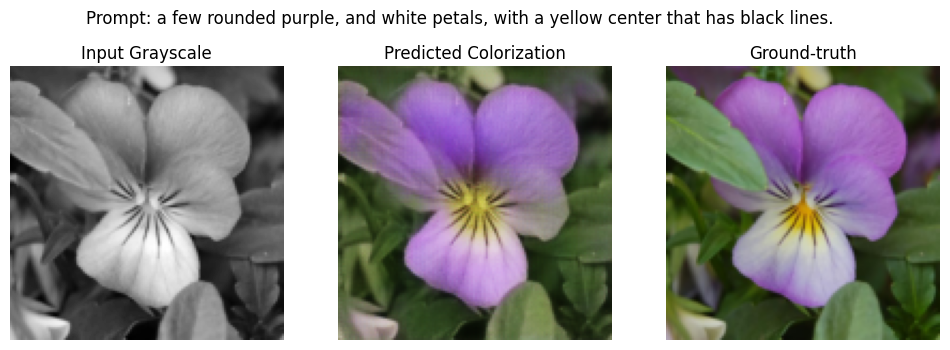

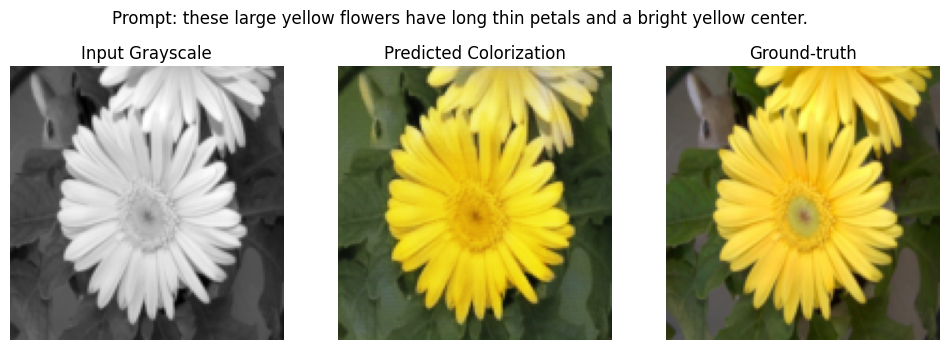

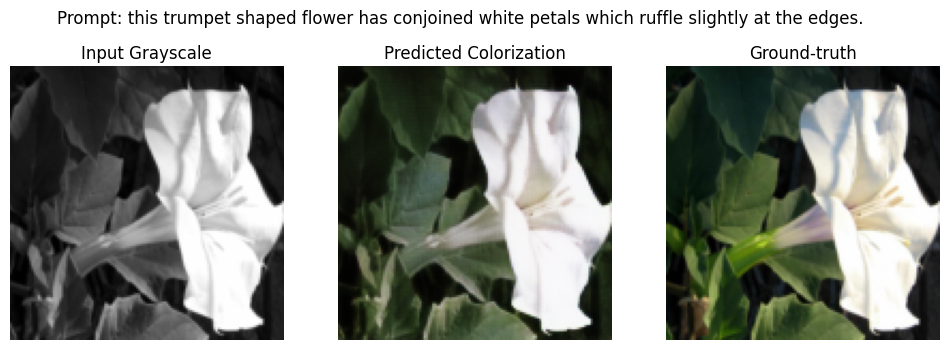

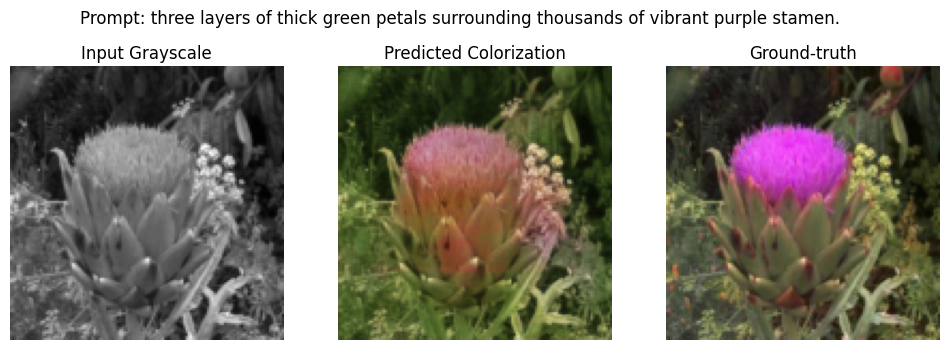

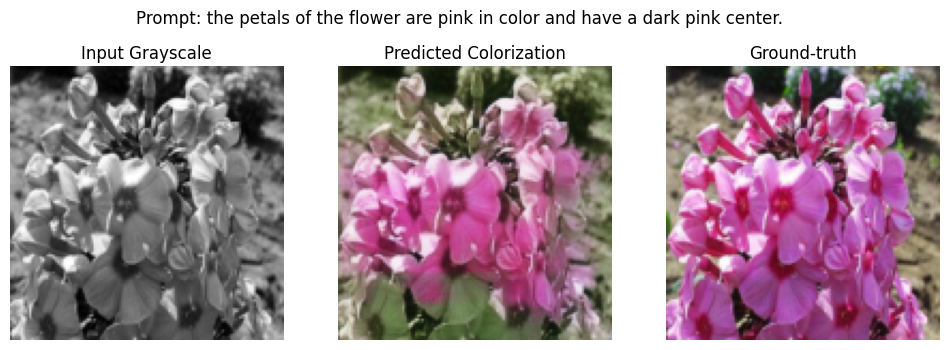

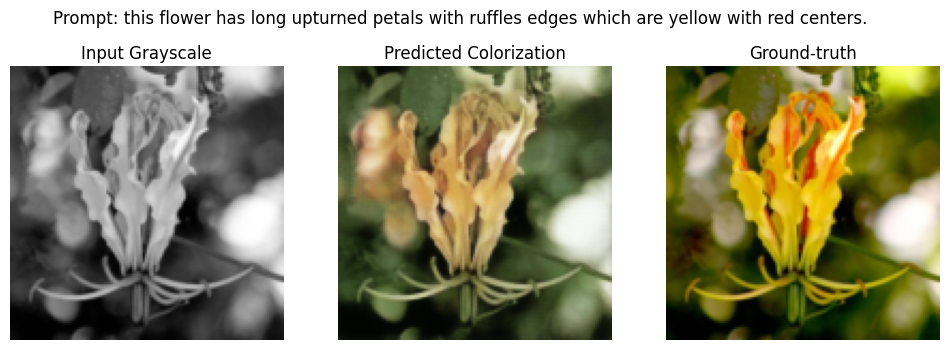

In [27]:
# -----------------------------
# Inference / plotting
# -----------------------------

def plot_sample(model_path, sample_index=0):
    # load dataset, keep same filtering and split
    ds = load_dataset(DATASET_ID, split='train')
    ds = ds.filter(lambda x: has_color_word(x['text']))

    # same 3-way split used in training
    ds = ds.train_test_split(test_size=0.04, seed=42)
    ds_trainval = ds['train']
    ds_test = ds['test']  # <-- NEVER seen during training
 
    text_encoder = TextEncoder(device=DEVICE)
    tokenizer = text_encoder.tokenizer
    test_dataset = FlowersColorDataset(ds_test, tokenizer)

    # pick sample
    sample = test_dataset[sample_index]
    gray = sample['gray'].unsqueeze(0).to(DEVICE)
    rgb_gt = sample['rgb'].permute(1,2,0).numpy()
    prompt = sample['text']

    # load model
    model = TextCondUNet(text_dim=text_encoder.model.config.hidden_size, base_ch=64).to(DEVICE)
    if model_path is not None:
        chk = torch.load(model_path, map_location=DEVICE)
        model.load_state_dict(chk['model_state_dict'])
    model.eval()

    # encode text
    input_ids = torch.tensor(sample['input_ids']).unsqueeze(0)
    attention_mask = torch.tensor(sample['attention_mask']).unsqueeze(0)
    text_emb = text_encoder.encode(input_ids, attention_mask)

    with torch.no_grad():
        pred = model(gray, text_emb)
    pred_img = pred.squeeze(0).permute(1,2,0).cpu().numpy()

    # input gray for plotting
    gray_img = gray.squeeze(0).squeeze(0).cpu().numpy()

    # plot
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(gray_img, cmap='gray')
    axs[0].set_title('Input Grayscale')
    axs[0].axis('off')

    axs[1].imshow(pred_img)
    axs[1].set_title('Predicted Colorization')
    axs[1].axis('off')

    axs[2].imshow(rgb_gt)
    axs[2].set_title('Ground-truth')
    axs[2].axis('off')

    plt.suptitle(f"Prompt: {prompt}")
    plt.show()


# nombre del archivo del modelo guardado durante el entrenamiento
model_path = "/kaggle/working/models_v2/unet_text_cond_epoch11_val0.008802.pt"

# probar varios seguidos
for i in np.random.choice(320, size=6, replace=False):
    plot_sample(model_path=model_path, sample_index=i)


### Métricas

In [15]:
def calculate_full_metrics(model_path, num_samples=300):   
    # load dataset, keep same filtering and split
    ds = load_dataset(DATASET_ID, split='train')
    ds = ds.filter(lambda x: has_color_word(x['text']))

    # same 3-way split used in training
    ds = ds.train_test_split(test_size=0.04, seed=42)
    ds_trainval = ds['train']
    ds_test = ds['test']  # <-- NEVER seen during training
 
    text_encoder = TextEncoder(device=DEVICE)
    tokenizer = text_encoder.tokenizer
    test_dataset = FlowersColorDataset(ds_test, tokenizer)

    if num_samples is not None and num_samples < len(ds_test):
        ds_test = ds_test.select(range(num_samples))
    
    
    # DataLoader para iterar eficientemente
    test_loader = DataLoader(
        test_dataset, 
        batch_size=4, 
        shuffle=False, 
        num_workers=2,
        collate_fn=collate_fn 
    )

    # load model
    model = TextCondUNet(text_dim=text_encoder.model.config.hidden_size, base_ch=64).to(DEVICE)
    if model_path is not None:
        chk = torch.load(model_path, map_location=DEVICE)
        model.load_state_dict(chk['model_state_dict'])
    model.eval()

    loss_fn_lpips = lpips.LPIPS(net='alex').to(DEVICE)
    loss_fn_lpips.eval()

    ssim_scores = []
    psnr_scores = []
    lpips_scores = []

   
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Calculando métricas"):
            # Mover a device
            gray = batch['gray'].to(DEVICE)         # (B, 1, H, W)
            rgb_gt = batch['rgb'].to(DEVICE)        # (B, 3, H, W) en [0, 1]
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)

            text_emb = text_encoder.encode(input_ids, attention_mask)
            pred_rgb = model(gray, text_emb)
            
            # Escalamos de [0, 1] -> [-1, 1]
            pred_norm = pred_rgb * 2 - 1
            gt_norm = rgb_gt * 2 - 1
            
            # LPIPS
            batch_lpips = loss_fn_lpips(pred_norm, gt_norm)
            lpips_scores.extend(batch_lpips.squeeze().cpu().tolist())

            # SSIM y PSNR 
            pred_np = pred_rgb.permute(0, 2, 3, 1).cpu().numpy()
            gt_np = rgb_gt.permute(0, 2, 3, 1).cpu().numpy()
            
            batch_size = pred_np.shape[0]
            for i in range(batch_size):
                p = np.clip(pred_np[i], 0, 1)
                g = np.clip(gt_np[i], 0, 1)
                
                # PSNR
                val_psnr = psnr_metric(g, p, data_range=1.0)
                psnr_scores.append(val_psnr)
                
                # SSIM (multicanal)
                val_ssim = ssim_metric(g, p, data_range=1.0, channel_axis=2)
                ssim_scores.append(val_ssim)

    mean_ssim = np.mean(ssim_scores)
    mean_psnr = np.mean(psnr_scores)
    mean_lpips = np.mean(lpips_scores)

    print("\n" + "="*40)
    print(f"RESULTADOS (sobre {len(lpips_scores)} imágenes):")
    print(f"Mean PSNR:  {mean_psnr:.4f} (Mayor es mejor)")
    print(f"Mean SSIM:  {mean_ssim:.4f} (Mayor es mejor)")
    print(f"Mean LPIPS: {mean_lpips:.4f} (Menor es mejor)")
    print("="*40)
    
    return mean_ssim, mean_psnr, mean_lpips

# nombre del archivo del modelo guardado durante el entrenamiento
model_path = "/kaggle/working/models_v2/unet_text_cond_epoch11_val0.008802.pt"

# Llamada a la función
m_ssim, m_psnr, m_lpips = calculate_full_metrics(model_path, num_samples=100)


README.md:   0%|          | 0.00/319 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/347M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8189 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8189 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
 40%|███▉      | 92.2M/233M [00:00<00:00, 243MB/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

100%|██████████| 233M/233M [00:01<00:00, 148MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Calculando métricas:   0%|          | 0/80 [00:00<?, ?it/s]


RESULTADOS (sobre 320 imágenes):
Mean PSNR:  21.7484 (Mayor es mejor)
Mean SSIM:  0.8412 (Mayor es mejor)
Mean LPIPS: 0.1776 (Menor es mejor)
